C:\Users\esteb\AppData\Local\Temp\ipykernel_19176\684161958.py:63: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  grid['dist_drain'] = centroids.geometry.distance(drains.unary_union)
C:\Users\esteb\AppData\Local\Temp\ipykernel_19176\684161958.py:64: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  grid['dist_fault'] = centroids.geometry.distance(faults.unary_union)
C:\Users\esteb\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


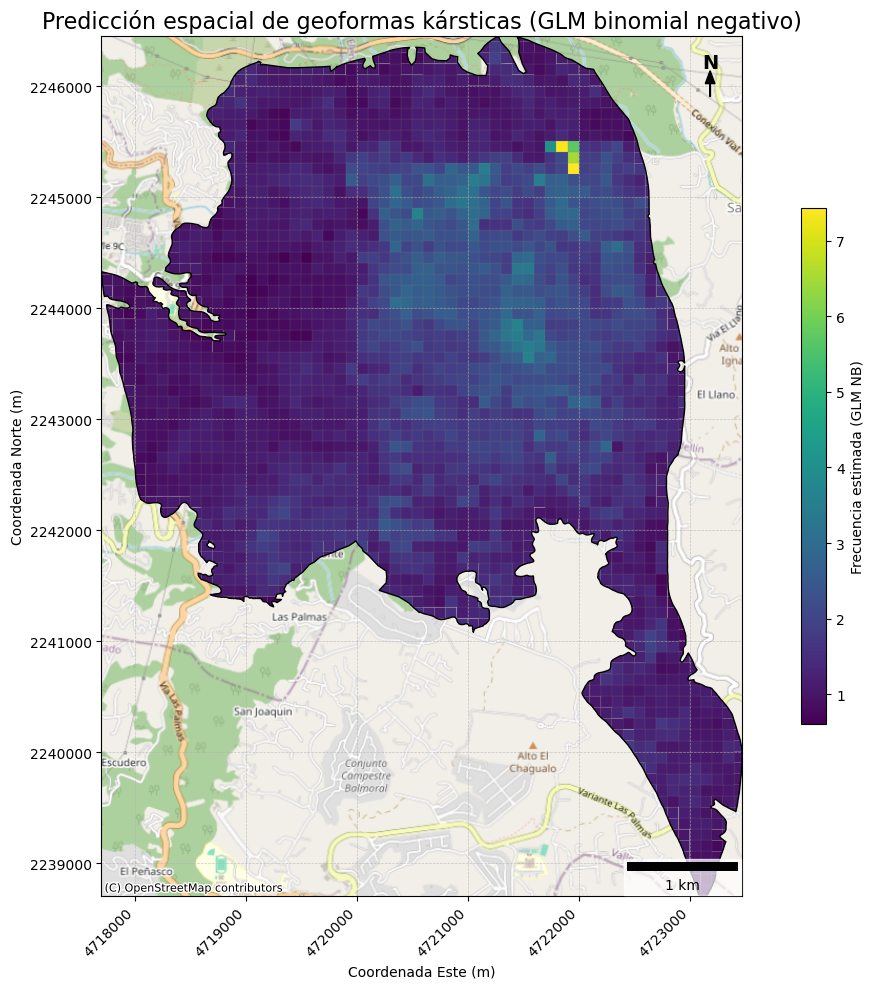

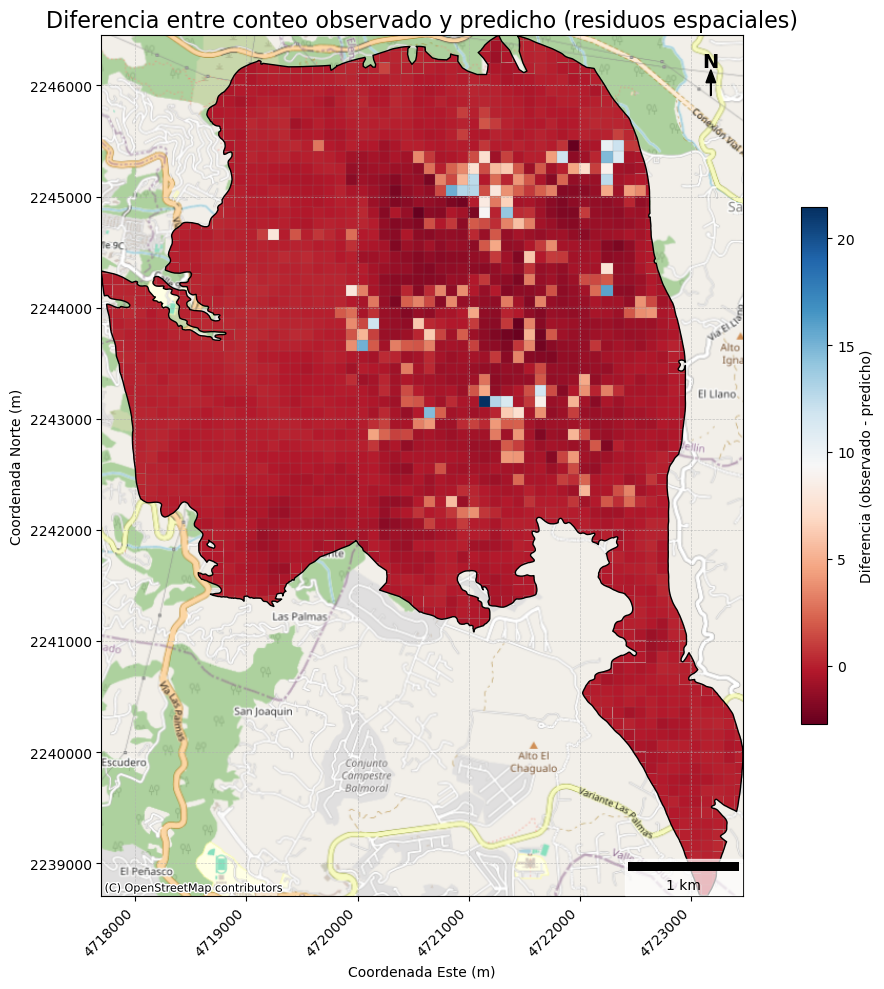

In [1]:
# Mapas de predicción y diferencia - GLM Binomial negativa

import os
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import box
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
import contextily as cx
import statsmodels.api as sm
from statsmodels.genmod.families import NegativeBinomial
from statsmodels.tools import add_constant
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.ticker import FuncFormatter

# Formateador de ejes como enteros 
def integer_formatter(x, pos):
    return f"{int(x)}"

# Rutas 
ruta_geoformas = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\SHP\Inventario_geoformas_karsticas_Dunita.shp"
ruta_contorno  = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\SHP\Contorno_Dunita.shp"
ruta_dem       = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\Raster\dem_clip.tif"
ruta_slope     = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\Raster\pendiente.tif"
ruta_twi       = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\Raster\TWI.tif"
ruta_cover     = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\SHP\Cobertura_final.shp"
ruta_drain     = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\SHP\Drenajes_clip_POT_final.shp"
ruta_fault     = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\SHP\Fallas_lineam.shp"
output_dir     = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\PNG"
os.makedirs(output_dir, exist_ok=True)

gdf_points  = gpd.read_file(ruta_geoformas)
gdf_contour = gpd.read_file(ruta_contorno)

# Cuadrícula 
cell_size = 100
minx, miny, maxx, maxy = gdf_contour.total_bounds
xs = np.arange(minx, maxx, cell_size)
ys = np.arange(miny, maxy, cell_size)
polygons = [box(x, y, x+cell_size, y+cell_size) for x in xs for y in ys]
grid = gpd.GeoDataFrame({'geometry': polygons}, crs=gdf_contour.crs)
grid = gpd.clip(grid, gdf_contour)

# Conteo por celda
join = gpd.sjoin(grid, gdf_points, how='left', predicate='intersects')
counts = join.groupby(join.index).size()
grid['count'] = counts.reindex(grid.index).fillna(0).astype(int)

# Covariables ráster
grid['dem_mean']   = [s['mean'] for s in zonal_stats(grid, ruta_dem,   stats=['mean'], nodata=-9999)]
grid['slope_mean'] = [s['mean'] for s in zonal_stats(grid, ruta_slope, stats=['mean'], nodata=-9999)]
grid['twi_mean']   = [s['mean'] for s in zonal_stats(grid, ruta_twi,   stats=['mean'], nodata=-9999)]

# Cobertura y distancias
cov_gdf  = gpd.read_file(ruta_cover)[['d_N3_COBER','geometry']].to_crs(grid.crs)
centroids = grid.copy(); centroids['geometry'] = centroids.centroid
cov_join = gpd.sjoin(centroids, cov_gdf, how='left', predicate='within')
grid['cover'] = cov_join['d_N3_COBER'].fillna('None')

drains = gpd.read_file(ruta_drain).to_crs(grid.crs)
faults = gpd.read_file(ruta_fault).to_crs(grid.crs)
grid['dist_drain'] = centroids.geometry.distance(drains.unary_union)
grid['dist_fault'] = centroids.geometry.distance(faults.unary_union)

# Preparar datos para el modelo
df = grid[['count','dem_mean','slope_mean','twi_mean','dist_drain','dist_fault','cover']].copy()
df = df.dropna(subset=['dem_mean','slope_mean','twi_mean'])
df = pd.get_dummies(df, columns=['cover'], prefix='cov', drop_first=True)
y = df['count'].astype(int)
X = df.drop(columns=['count']).astype(float)
X = add_constant(X)

# Ajustar modelo 
model = sm.GLM(y, X, family=NegativeBinomial())
results = model.fit()

# Predicción
grid_pred = grid.loc[df.index].copy()
grid_pred['predicted'] = results.predict(X)

# Mapa de frecuencia predicha
fig, ax = plt.subplots(figsize=(12, 10))
grid_pred.plot(column='predicted', cmap='viridis', edgecolor='grey', linewidth=0.1,
               legend=True, legend_kwds={'label': "Frecuencia estimada (GLM NB)", 'shrink': 0.6}, ax=ax)
gdf_contour.boundary.plot(ax=ax, edgecolor='black', linewidth=1)

# Estética
ax.set_title("Predicción espacial de geoformas kársticas (GLM binomial negativo)", fontsize=16)
ax.set_xlabel("Coordenada Este (m)")
ax.set_ylabel("Coordenada Norte (m)")
ax.xaxis.set_major_formatter(FuncFormatter(integer_formatter))
ax.yaxis.set_major_formatter(FuncFormatter(integer_formatter))
plt.xticks(rotation=45, ha='right')

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_aspect('equal', 'box')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

cx.add_basemap(ax, crs=grid_pred.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik, zoom='auto')
ax.add_artist(ScaleBar(dx=1, units="m", location="lower right", frameon=True, color='black', box_alpha=0.7))

# Flecha de norte ajustada
x_n, y_n = 0.95, 0.97
ax.text(x_n, y_n, "N", transform=ax.transAxes, ha="center", va="center", fontsize=14, fontweight="bold", zorder=5)
ax.arrow(x_n, y_n - 0.04, 0, 0.03, transform=ax.transAxes,
         head_width=0.015, head_length=0.015, fc='black', ec='black',
         length_includes_head=True, zorder=5)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'mapa_frecuencia_predicha_100m_cartografico.png'), dpi=300, bbox_inches='tight')
plt.show()

# Mapa de diferencia
grid_resid = grid.loc[df.index].copy()
grid_resid['residual'] = grid_resid['count'] - grid_pred['predicted']

fig, ax = plt.subplots(figsize=(12, 10))
grid_resid.plot(column='residual', cmap='RdBu', edgecolor='grey', linewidth=0.1,
                legend=True, legend_kwds={'label': "Diferencia (observado - predicho)", 'shrink': 0.6}, ax=ax)
gdf_contour.boundary.plot(ax=ax, edgecolor='black', linewidth=1)

# Estética
ax.set_title("Diferencia entre conteo observado y predicho (residuos espaciales)", fontsize=16)
ax.set_xlabel("Coordenada Este (m)")
ax.set_ylabel("Coordenada Norte (m)")
ax.xaxis.set_major_formatter(FuncFormatter(integer_formatter))
ax.yaxis.set_major_formatter(FuncFormatter(integer_formatter))
plt.xticks(rotation=45, ha='right')

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_aspect('equal', 'box')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

cx.add_basemap(ax, crs=grid_resid.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik, zoom='auto')
ax.add_artist(ScaleBar(dx=1, units="m", location="lower right", frameon=True, color='black', box_alpha=0.7))

# Flecha de norte ajustada
x_n, y_n = 0.95, 0.97
ax.text(x_n, y_n, "N", transform=ax.transAxes, ha="center", va="center", fontsize=14, fontweight="bold", zorder=5)
ax.arrow(x_n, y_n - 0.04, 0, 0.03, transform=ax.transAxes,
         head_width=0.015, head_length=0.015, fc='black', ec='black',
         length_includes_head=True, zorder=5)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'mapa_diferencia_observado_predicho_100m_cartografico.png'), dpi=300, bbox_inches='tight')
plt.show()
